<a href="https://colab.research.google.com/github/vu-topics-in-big-data-2021/project-crypto-group16/blob/main/Query4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Query 4
What is the relationship between daily deaths / daily covid cases and the volatility of a currency? We hypothesize that with rises in cases and deaths that we will see an increase in volatility for a currency. 


## Setup

In [1]:
#install the required packages
!pip3 install influxdb plotly pandas numpy matplotlib

     |████████████████████████████████| 81kB 3.8MB/s 


In [2]:
from influxdb import InfluxDBClient
import json
import datetime
from getpass import getpass
import pandas as pd
import numpy as np
import seaborn as sns
from matplotlib.pylab import rcParams
from plotly.subplots import make_subplots
import plotly.graph_objects as go
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import matplotlib.dates as mdates

In [3]:
u1=getpass('Enter Username Here:')
p1=getpass('Enter Password Here:')
covid_client = InfluxDBClient(host='34.202.233.175', username=u1, password=p1, port=8086, database="covid")

Enter Username Here:··········
Enter Password Here:··········


In [4]:
print('existing databases for covid data:', covid_client.get_list_database())

existing databases for covid data: [{'name': '_internal'}, {'name': 'covid'}]


In [5]:
u2=getpass('Enter Username Here:')
p2=getpass('Enter Password Here:')
forex_client = InfluxDBClient(host='100.25.103.36', username=u2, password=p2, port=8086, database="crypto_forex")

Enter Username Here:··········
Enter Password Here:··········


In [6]:
try:
    d = forex_client.get_list_database()
    assert str(d) == "[{'name': '_internal'}, {'name': 'crypto_forex'}]"
    print("Successfully connected to DB")
except AssertionError:
    print("InfluxDB not configured correctly. Databases listed below")
    print(forex_client.get_list_database())
    quit()

Successfully connected to DB


In [7]:
def tema_sigma(pair):
    """
    :return: DataFrame
    """
    query_str= f"""
    SELECT TRIPLE_EXPONENTIAL_MOVING_AVERAGE(stddev("c"),8) AS sigma_{pair[2:]}
    FROM crypto_forex
    WHERE time >= '2020-02-14T00:00:00Z'
    AND time < '2021-04-01T00:00:00Z'
    AND pair = '{pair}' 
    GROUP BY time(1w)
    FILL(null)
    """
    df = pd.DataFrame(forex_client.query(query_str).get_points('crypto_forex'))
    df["time"] = df["time"].apply(lambda x: datetime.datetime.strptime(x, "%Y-%m-%dT%H:%M:%SZ"))
    df = df.set_index("time")
    return df

In [8]:
def std_close(pair):
    """
    :return: DataFrame
    """
    query_str= f"""
    SELECT stddev(c) AS std_c_{pair[2:]}
    FROM crypto_forex
    WHERE time > '2020-02-14T00:00:00Z'
    AND time < '2021-04-01T00:00:00Z'
    AND pair = '{pair}' 
    GROUP BY time(7d)
    FILL(null)
    """
    df = pd.DataFrame(forex_client.query(query_str).get_points("crypto_forex"))
    df["time"] = df["time"].apply(lambda x: datetime.datetime.strptime(x, "%Y-%m-%dT%H:%M:%SZ"))
    df.index=df.set_index("time")
    return df


In [9]:
def daily_new(country):
    query_str = """
    SELECT mean("daily_new_cases") AS "mean daily new cases"
    FROM covid WHERE time > \'2020-02-14T00:00:00Z\' 
    AND time < \'2021-04-01T00:00:00Z\'
    AND "country"=\'{}\'
    GROUP BY time(7d)
    FILL(null)""".format(country)
  
    try:
        df = pd.DataFrame(covid_client.query(query_str).get_points('covid'))
        df["time"] = df["time"].apply(lambda x: datetime.datetime.strptime(x, "%Y-%m-%dT%H:%M:%SZ"))
        # df.index=df.set_index("time")
    except Exception as e:
        print(e)
    return df


def daily_death(country):
    query_str = """
    SELECT mean("daily_new_deaths") AS "mean daily deaths"
    FROM covid WHERE time > \'2020-02-14T00:00:00Z\' 
    AND time < \'2021-04-01T00:00:00Z\'
    AND "country"=\'{}\'
    GROUP BY time(7d)
    FILL(null)""".format(country)
  
    try:
        df = pd.DataFrame(covid_client.query(query_str).get_points('covid'))
        df["time"] = df["time"].apply(lambda x: datetime.datetime.strptime(x, "%Y-%m-%dT%H:%M:%SZ"))
        # df.index=df.set_index("time")
    except Exception as e:
        print(e)
    return df

In [10]:
def q_join(pairList):
    df = pd.DataFrame()
    for i in pairList:
        tmp_df = tema_sigma(i)
        if df.empty:
           df = tmp_df
        else:
            new_df = pd.merge(left=df,
                              right=tmp_df,
                              how="left",
                              on = "time",
                              left_index=True)
            df = new_df
    return df

## Query

In [11]:
usa_c = daily_new("USA")
usa_d = daily_death("USA")
usa_c.index = usa_c["time"]
usa_d.index = usa_d["time"]
usa_c = usa_c.drop("time", axis=1)
usa_d = usa_d.drop("time", axis=1)

In [12]:
forex = q_join(["C:EURUSD","X:BTCUSD"])

In [13]:
usa = pd.merge(left=usa_c,
                  right=usa_d,
                  how="left",
                  on = "time",
                  left_index=True)

In [14]:
df = pd.merge(left=forex,
              right=usa,
              how="left",
              left_index=True,
              right_index=True)

In [15]:
rc = df.drop(axis=1, labels=["mean daily new cases", "mean daily deaths", "sigma_BTCUSD", "sigma_EURUSD"])
rc["Correlation between Daily New Cases and Sigma BTCUSD"] = df["mean daily new cases"].rolling(7).corr(df["sigma_BTCUSD"])
rc["Correlation between Daily Deaths and Sigma BTCUSD"] = df["mean daily deaths"].rolling(7).corr(df["sigma_BTCUSD"])
rc["Correlation between Daily New Cases and Sigma EURUSD"] = df["mean daily new cases"].rolling(7).corr(df["sigma_EURUSD"])
rc["Correlation between Daily Deaths and Sigma EURUSD"] = df["mean daily deaths"].rolling(7).corr(df["sigma_EURUSD"])
rc = rc.dropna()
rc.head(3)

,Correlation between Daily New Cases and Sigma BTCUSD,Correlation between Daily Deaths and Sigma BTCUSD,Correlation between Daily New Cases and Sigma EURUSD,Correlation between Daily Deaths and Sigma EURUSD
time,,,,
2020-05-07,-0.623568,-0.845645,-0.344639,-0.814168
2020-05-14,-0.245494,-0.620860,0.216281,-0.507192
2020-05-21,-0.415953,-0.285857,-0.451478,-0.559354


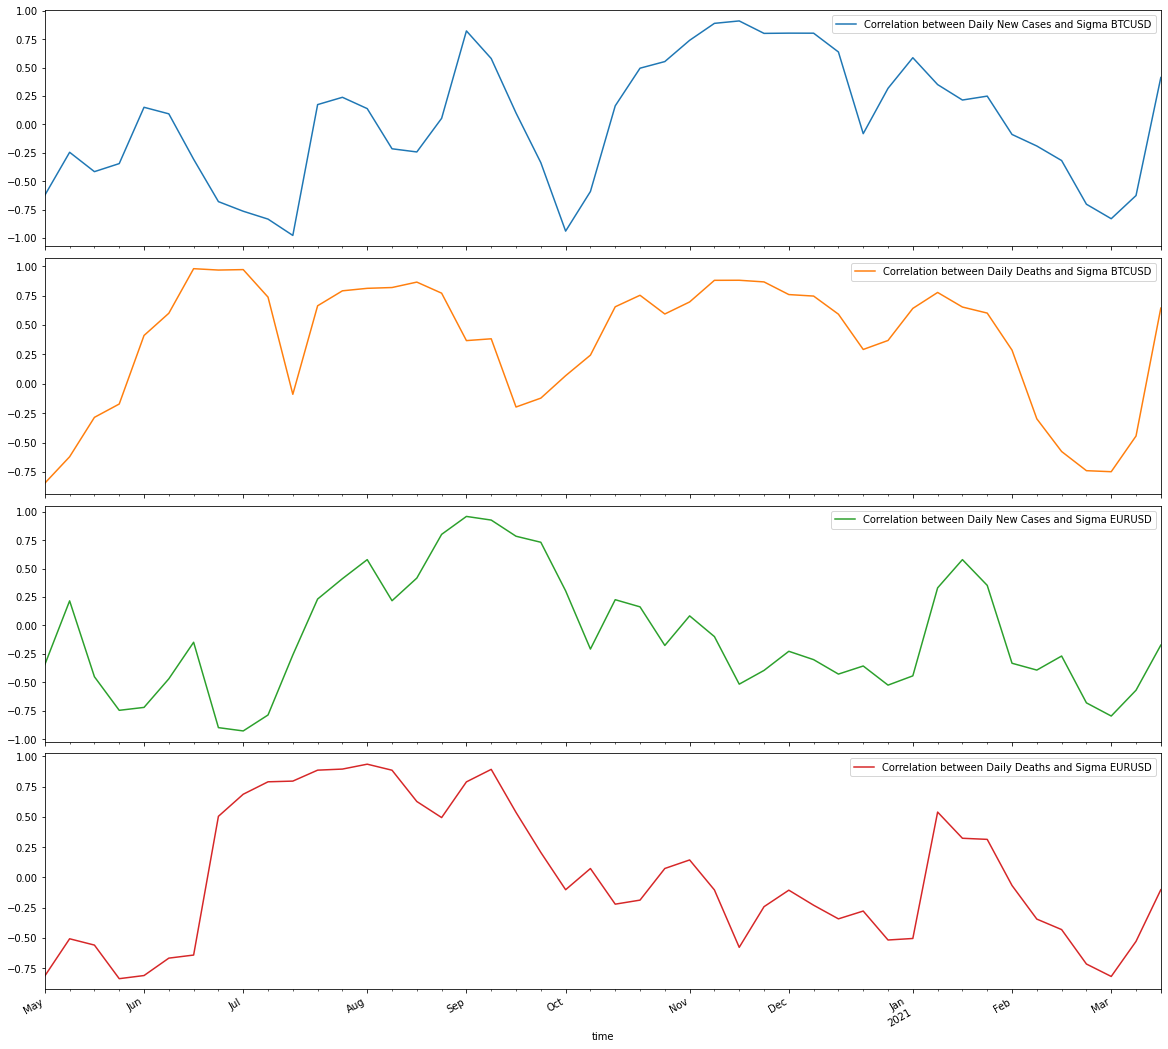

In [21]:
rc.plot(figsize=(20,5*len(rc.columns)), subplots=True)
plt.subplots_adjust(wspace=0.50, hspace=0.05)

## Commentary 
Although we thought that we may see that there is some correlation between daily cases or deaths and volatility of a major currency, we actually did not see any consistent patterns. 